# Proyecto 1: Identificando números con imágenes
En este ejercicio analizaras e identificarás números dados en la forma de imagen. Para ello puedes utilizar tu solución preferida identificar grupos de imágenes similares. Por ejemplo, puedes aplicar reducción de dimensionalidad antes o después del entrenamiento, puedes también elegir no usarlo. Para hacer la predicción puedes hacer uso de un método de agrupamiento y resolver la tarea con aprendizaje no supervisado, o puedes utilizar un algoritmo de clasificación y elegir el camino de aprendizaje supervisado.

A diferencia de los ejercicios anteriores donde programaste las soluciones analíticas a los métodos de ML, en este proyecto se recomienda el uso de las funciones y clases integradas de scikit-learn. Para entender el uso de estas clases y ver algunos ejemplos puedes consultar la documentación oficial
- [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)
- [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
- [DBScan](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

En este proyecto tendrás que elegir que método de reducción de dimensionalidad y que método de agrupamiento deseas aplicar a tus datos. Es tu trabajo analizar la información dada para tomar estas decisiones. Lee con atención todas las instrucciones y celdas de código, y recuerda agregar tu código en todas las partes donde veas la instrucción "`TODO`"

## Descripción
Tu trabajo es identificar grupos en imágenes para reconocimiento de números. Para esto, deberás realizar los siguientes pasos:
1. Dado que nuestros datos están en diferentes escalas, es necesario normalizar los datos.
2. Aplicar un método de reducción de dimensionalidad y visualizar los datos
3. Buscar grupos en los datos reducidos con alguna técnica de agrupamiento.
4. Interpretar los resultados de los clusters
5. Dado dos imágenes nuevas (set de validación), identificar a que grupo pertenece. (Inferencia)

Comenzamos por importar las librerías correspondientes.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

 ## 1. Analizando los datos
 Comenzamos leyendo nuestros datos y visualizando algunos ejemplos para analizarlos. En este caso utilizaremos el [digits dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html#sphx-glr-auto-examples-datasets-plot-digits-last-image-py). En este dataset encontrarás 1797 imágenes de 8x8. Cada imagen es un dígito escrito a mano. Primero separaremos los datos en entrenamiento y validación

 Recuerda! los datos de entranmiento *son los únicos* que puedes usar para entrenar tus modelos. El conjunto de validación solo se utilizará para evaluar el rendimiento de los modelos que elijas.

In [45]:
# Cargamos nuestros datos y los separamos en entrenamiento y validación
data, labels = load_digits(return_X_y=True)
data_train, data_val, target_train, target_val = train_test_split(
    data, 
    labels, 
    test_size=0.25
)
print(f"Imágenes en rango {np.max(data)}, {np.min(data)}")

# Entrenamiento
(n_samples, n_features), n_digits = data_train.shape, np.unique(target_train).size
print(f"# Dígitos: {n_digits}; # Muestras de entrenamiento: {n_samples}; # Variables {n_features}")

# Validación
(n_samples, n_features), n_digits = data_val.shape, np.unique(target_val).size
print(f"# Dígitos: {n_digits}; # Muestras de validación: {n_samples}; # Variables {n_features}")

Imágenes en rango 16.0, 0.0
# Dígitos: 10; # Muestras de entrenamiento: 1347; # Variables 64
# Dígitos: 10; # Muestras de validación: 450; # Variables 64


En este ejercicio las imágenes se entregan como un vector de 64 variables, donde cada elemento corresponde al valor de un pixel. Para visualizar los datos en forma de imagen, es necesario transformarlos a la forma adecuada. En las siguiente celda puedes ver algunas imágenes de ejemplo, así como la forma en que podemos transformar el vector de variables a una matriz de 8x8.

<Figure size 640x480 with 0 Axes>

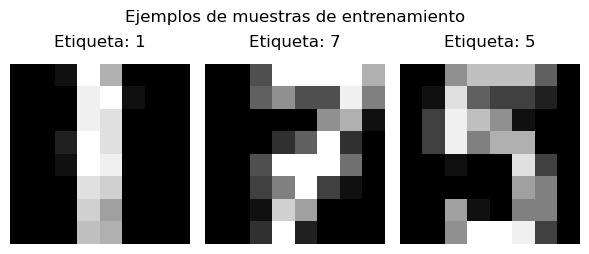

In [46]:
plt.gray()

# Visualizar algunas imágenes
n_cols = 3
idx = np.random.randint(len(data_train), size=n_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(6,3))
axes = axes.flatten()
for ax, i in zip(axes, idx):
    side = np.sqrt(len(data_train[i])).astype('int')
    # La imagen está dada como un solo vector de longitud 64
    # Cambiamos la forma para tenerla en forma de imagen de 8x8 pixeles
    img = data[i].reshape((side, side))
    ax.matshow(img)
    ax.axis('off')
    ax.set_title(f"Etiqueta: {labels[i]}")
fig.suptitle("Ejemplos de muestras de entrenamiento")
plt.tight_layout()
plt.show()

## Visualización en baja dimensionalidad
En la siguiente celda puedes visualizar como se ven tus datos reduciendo la dimensionalidad de 30 variables a 2. Explora usar TSNE y PCA, y elige el que te de mejor información.

¿Cual método de reducción de dimensionalidad funciona mejor en este caso?


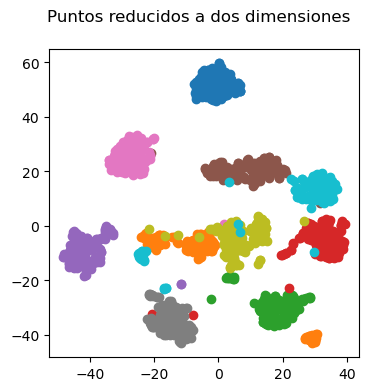

In [82]:
# TODO Reducimos la dimensionalidad de los datos de validacion data_val
# a 2 dimensiones usando TSNE y/o PCA
reduced_data = TSNE(n_components=2).fit_transform(data_train)
# reduced_data = PCA(n_components=2).fit_transform(data_train)

labels = np.unique(target_train)
fig, ax_pca = plt.subplots(1, 1, figsize=(4,4))
fig.suptitle("Puntos reducidos a dos dimensiones")
for c in labels:
    indices = np.where(target_train == c)
    plot_data = reduced_data[indices]
    ax_pca.scatter(plot_data[:, 0], plot_data[:, 1], label=f"Grupo {c}")
plt.show()

# 2. Funciones de utilidad
En la siguiente sección definimos algunas funciones que podrías llegar a necesitar. Esto depende completamente de como decidas implementar tu algoritmo. Lee la descripción de las siguientes funciones y determina si las necesitas.

In [47]:
def bench_clustering(clustering_method, name, data, labels):
    '''
        Calcula el silhouette_score para un algoritmo de clustering
    '''
    normalized_data = StandardScaler().fit(data)
    estimator = clustering_method.fit(data)

    idx = np.where(estimator.labels_ > -1)
    valid_data = data[idx]
    labels = estimator.labels_[idx]
    cluster_labels = np.unique(labels)
    if len(cluster_labels) > 1:
        # The silhouette score requires the full dataset
        score = metrics.silhouette_score(valid_data,
                                         labels,
                                         metric="euclidean")
    else: # No se puede calcular el silhouette_score para 1 solo cluster
        score = -1
    # Show the results
    print(f"{name}\t{score:.3f}\tn_clusters:{len(cluster_labels)}")

n_spaces = 50
print(n_spaces * "_")
kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_clustering(kmeans, name="KMeans random init", data=data_train, labels=target_train)

dbscan = DBSCAN(eps=15,min_samples=4)
bench_clustering(dbscan, name="DBscan", data=data_train, labels=target_train)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_clustering(kmeans, name="KMeans PCA-based", data=data_train, labels=target_train)

print(n_spaces * "_")

__________________________________________________
KMeans random init	0.184	n_clusters:10
DBscan	0.375	n_clusters:25
KMeans PCA-based	0.166	n_clusters:10
__________________________________________________


In [48]:
# DBScan no tiene una definición para predecir nuevos datos,
# puedes usar el siguiente código para hacer inferencia con dbscan
import scipy as sp
def dbscan_predict(dbscan_model, X_new, metric=sp.spatial.distance.cosine):
    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 
    # Iterate all input samples for a label
    for j, x_new in enumerate(X_new):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(dbscan_model.components_): 
            if metric(x_new, x_core) < dbscan_model.eps:
                # Assign label of x_core to x_new
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
                break
    return y_new

# 3. Tu turno!
Datos los datos `data_train` con las etiquetas `target_train` define y entrena un algoritmo que identifique dígitos. Puedes utilizar tu método preferido. Utiliza las librerías de scikit learn. En la sección de abajo encontrarás un código que puedes usar para probar tu algoritmo. Agrega el código necesario en el método de `mi_modelo` para entrenar el modelo que decidas usar

## Modelo de agrupamiento

In [60]:
# Normalizamos los datos
scaler = StandardScaler()
scaler.fit(data_train)

def mi_modelo(X, label):
    # Normalizamos los datos de entrenamiento
    data = scaler.transform(X)

    # Entrenamos el modelo
    pca = PCA(n_components=n_digits).fit(data)
    kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
    estimator = kmeans.fit(data)
    return estimator

def mi_inferencia(modelo, X_val):
    # Normalizamos los datos de validación
    data = scaler.transform(X_val)

    # Predecimos
    pred = modelo.predict(X_val)
    # Si utilizas DBScan
    return pred

modelo = mi_modelo(data_train, target_train)
pred = mi_inferencia(modelo, data_val)

## Modelo de regresión logística

In [50]:
# Normalizamos los datos
scaler = StandardScaler()
scaler.fit(data_train)

def mi_modelo(X, label):
    # Normalizamos los datos de entrenamiento
    data = scaler.transform(X)

    # Entrenamos el modelo
    model = LogisticRegression().fit(data, label)
    return model

def mi_inferencia(modelo, X_val):
    # Normalizamos los datos de validación
    data = scaler.transform(X_val)

    # Predecimos
    pred = modelo.predict(X_val)
    return pred

modelo = mi_modelo(data_train, target_train)
pred = mi_inferencia(modelo, data_val)

# 4. Evaluación y análisis de las predicciones
En esta sección incluimos funciones que te permiten visualizar la predicción de tu modelo para el set de validación. Dado que nuestros datos son de alta dimensionalidad (64) necesitamos reducirlos para poder analizar las predicciones. Recuerda que en esta sección solo funcionará si has definido tu modelo correctamente en el método anterior `mi_modelo`.

\# TODO:
Completa el código de la siguiente celda para visualizar las predicciones de el dataset de validación en baja dimensionalidad. Utiliza el método de reducción de dimensionalidad que consideres te ayude mejor a analizar tus datos. Cada clase/grupo deberá mostrarse en un color diferente. En base a lo que puedes observar en la imagen, ¿consideras que tu algoritmo ha aprendido algo que tiene sentido?

Datos (450, 64), predicciones (450,), clases/grupos 10


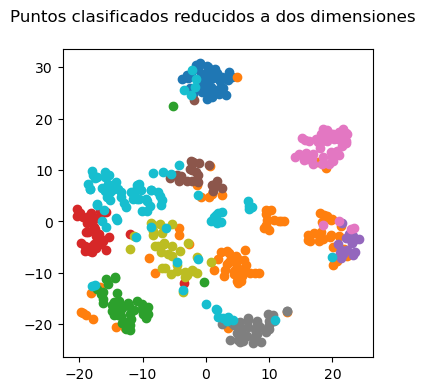

In [52]:
reduced_data = TSNE(n_components=2).fit_transform(data_val)
# reduced_data = PCA(n_components=2).fit_transform(data_val)

# Llamamos a inferencia de su modelo
preds = mi_inferencia(modelo, data_val)
group_pred = np.unique(preds)
n_groups = len(group_pred)

# Graficamos los datos, con un color diferente para cada clase/grupo
print(f"Datos {data_val.shape}, predicciones {preds.shape}, clases/grupos {n_groups}")

fig, ax_pca = plt.subplots(1, 1, figsize=(4,4))
fig.suptitle("Puntos clasificados reducidos a dos dimensiones")
for group in group_pred:
    indices = np.where(preds == group)
    plot_data = reduced_data[indices]
    ax_pca.scatter(plot_data[:, 0], plot_data[:, 1], label=f"Grupo {group}")
plt.show()

## 4.2 Visualizar imagenes en cada grupo/clase
El siguiente código llama al método de inferencia y muestra 1 imagen aleatoria por cada grupo de predicción de tu modelo.

#### Métodos de clasificación
Si utilizaste un método de clasificación multiclase, los esperable sería que el valor real de la muestra (GT) sea igual al valor de la predicción para al menos la mayoría de los casos.

#### Métodos de agrupamiento
Si utilizaste un algoritmo de agrupamiento, es esperable que el valor real de la muestra (GT) no sea igual al grupo de tu predicción. Recuerda que al ser aprendizaje no supervisado, necesitamos adicionalmente "mapear" los grupos que haya encontrado el algoritmo a los reales. Puedes usar esta sección para hacer dicho mapeo. Lo mas sencillo es usar un diccionario

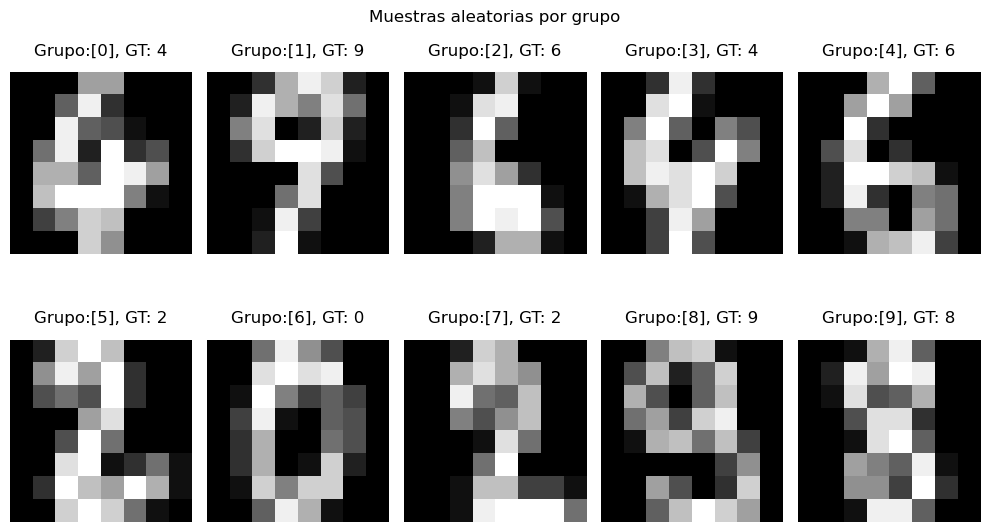

In [72]:
# Llamamos a inferencia de su modelo
# Este método regresará una cantidad definida de clases
# Que haya encontrado para los datos de validación
preds = mi_inferencia(modelo, data_val)
group_pred = np.unique(preds)
n_groups = len(group_pred)

# Graficar
n_cols = 5
fig, axes = plt.subplots(n_groups//n_cols, n_cols, figsize=(10,6))
axes = axes.flatten()
for group, ax in zip(group_pred, axes):
    # Mostrar una imagen aleatoria por grupo
    indices = np.where(preds == group)
    rand_idx = np.random.choice(indices[0])
    img_vector = data_val[rand_idx].reshape(1, -1)

    # Hacer inferencia en su modelo
    pred = mi_inferencia(modelo, img_vector)
    
    # Cambiamos la forma para tenerla en forma de imagen de 8x8 pixeles
    img = img_vector.reshape((side, side))
    ax.matshow(img)
    ax.set_title(f"Grupo:{pred}, GT: {target_val[rand_idx]}")
    ax.axis('off')
fig.suptitle("Muestras aleatorias por grupo")
plt.tight_layout()
plt.show()